In [1]:
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sb
import os
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import tensorflow.keras.layers as tfl
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import glob as gb
import cv2
from tensorflow import keras

from keras import backend as K
from keras.models import Sequential, Model,load_model
from keras.callbacks import EarlyStopping,ModelCheckpoint
from keras.layers import Dropout, Input, Add, Dense, Activation, ZeroPadding2D, GlobalAveragePooling2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D,MaxPool2D
from keras.preprocessing import image
from keras.initializers import glorot_uniform

# Model
from tensorflow.keras.optimizers import Adam

# Model Checks
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
import itertools


import matplotlib.pyplot as plt 
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import roc_curve, auc, roc_auc_score
from itertools import cycle

#Model Graphs
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style('whitegrid')
# Set the style to whitegrid
plt.style.use('seaborn-whitegrid')
plt.style.library['seaborn-whitegrid']
plt.style.use("seaborn-v0_8-whitegrid")

from matplotlib import rcParams
rcParams['font.weight'] = 'bold'

2024-05-29 08:07:05.503579: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-29 08:07:05.503682: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-29 08:07:05.638260: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Preparing dataset**

In [2]:
def data(dataset_path):
    images = []
    labels = []
    for subfolder in os.listdir(dataset_path):
        subfolder_path = os.path.join(dataset_path, subfolder)
        if not os.path.isdir(subfolder_path):
            continue
        for image_filename in os.listdir(subfolder_path):
            if image_filename.endswith(".jpg"):
                image_path = os.path.join(subfolder_path, image_filename)
                images.append(image_path)
                labels.append(subfolder)
    df = pd.DataFrame({'image': images, 'label': labels})
    return df

# **Reading Dataset**

In [3]:
# train data
train=data('/kaggle/input/bone-fracture/dataset/train')
train.head()

,image,label
0,/kaggle/input/bone-fracture/dataset/train/not ...,not fractured
1,/kaggle/input/bone-fracture/dataset/train/not ...,not fractured
2,/kaggle/input/bone-fracture/dataset/train/not ...,not fractured
3,/kaggle/input/bone-fracture/dataset/train/not ...,not fractured
4,/kaggle/input/bone-fracture/dataset/train/not ...,not fractured


In [4]:
# test data
test=data('/kaggle/input/bone-fracture/dataset/test')
test.head()

,image,label
0,/kaggle/input/bone-fracture/dataset/test/not f...,not fractured
1,/kaggle/input/bone-fracture/dataset/test/not f...,not fractured
2,/kaggle/input/bone-fracture/dataset/test/not f...,not fractured
3,/kaggle/input/bone-fracture/dataset/test/not f...,not fractured
4,/kaggle/input/bone-fracture/dataset/test/not f...,not fractured


In [5]:
# test data
val=data('/kaggle/input/bone-fracture/dataset/val')
val.head()

,image,label
0,/kaggle/input/bone-fracture/dataset/val/not fr...,not fractured
1,/kaggle/input/bone-fracture/dataset/val/not fr...,not fractured
2,/kaggle/input/bone-fracture/dataset/val/not fr...,not fractured
3,/kaggle/input/bone-fracture/dataset/val/not fr...,not fractured
4,/kaggle/input/bone-fracture/dataset/val/not fr...,not fractured


# **Data Visulaization**

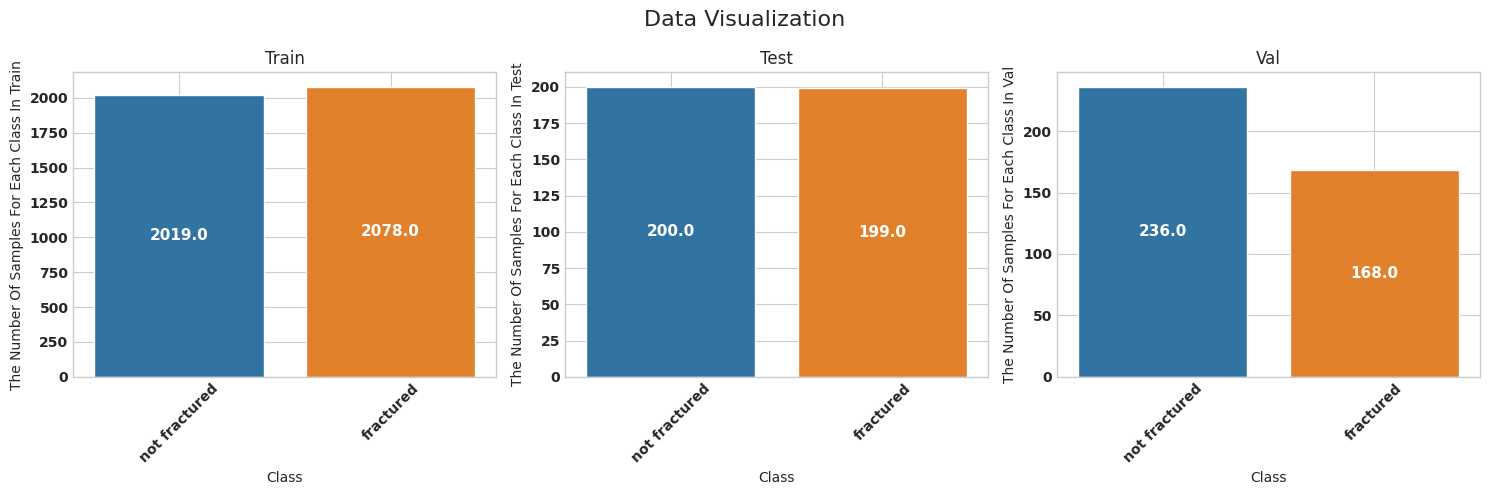

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Function to add annotations to the bars
def add_counts(ax):
    for p in ax.patches:
        height = p.get_height()
        if height > 0:  
            ax.annotate(f'{height}', 
                        (p.get_x() + p.get_width() / 2., height / 2),  # Position in the middle
                        ha='center', va='center', fontsize=11, color='white')

plt.figure(figsize=(15, 5))
plt.suptitle('Data Visualization', fontsize=16)

# Train plot
plt.subplot(1, 3, 1)
ax1 = sns.countplot(x=train.label)
ax1.set_xlabel("Class")
ax1.set_ylabel("The Number Of Samples For Each Class In Train")
plt.title('Train')
plt.grid(True)
plt.xticks(rotation=45)
add_counts(ax1)

# Test plot
plt.subplot(1, 3, 2)
ax2 = sns.countplot(x=test.label)
ax2.set_xlabel("Class")
ax2.set_ylabel("The Number Of Samples For Each Class In Test")
plt.title('Test')
plt.grid(True)
plt.xticks(rotation=45)
add_counts(ax2)

# Validation plot
plt.subplot(1, 3, 3)
ax3 = sns.countplot(x=val.label)
ax3.set_xlabel("Class")
ax3.set_ylabel("The Number Of Samples For Each Class In Val")
plt.title('Val')
plt.grid(True)
plt.xticks(rotation=45)
add_counts(ax3)

plt.tight_layout()
plt.show()


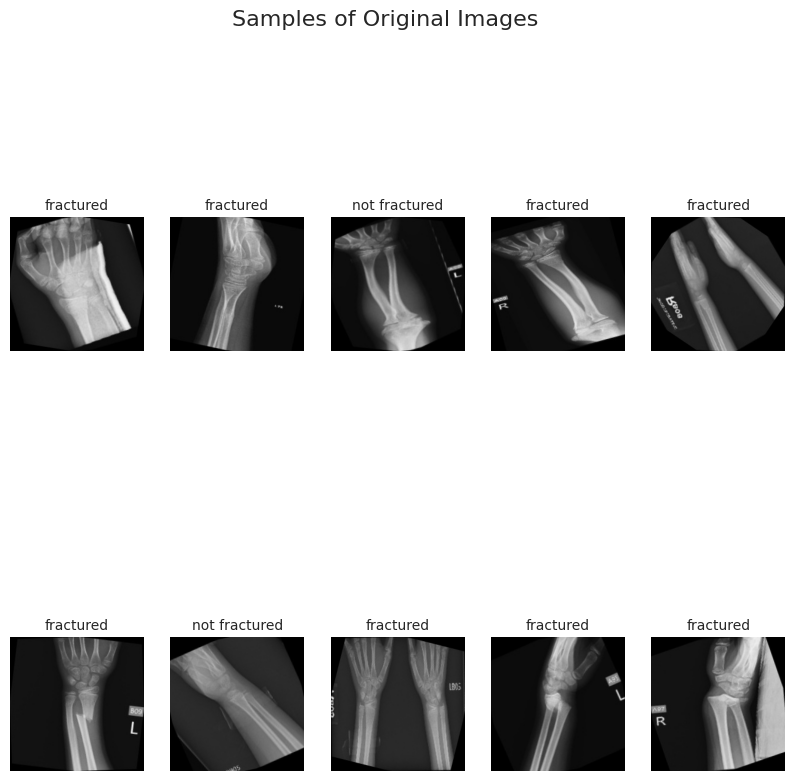

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import cv2

# Assuming 'train' DataFrame has columns 'image' and 'label'

plt.figure(figsize=(10, 10))
for n, i in enumerate(np.random.randint(0, len(train), 10)):
    plt.subplot(2, 5, n + 1)
    img = cv2.imread(train.image[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB for correct color display
    plt.imshow(img)
    plt.axis('off')
    plt.title(train.label[i], fontsize=10)

# Add a main title
plt.suptitle('Samples of Original Images', fontsize=16)


plt.show()


# **Data Augmentation**

In [8]:
image_size = (224, 224)
batch_size = 32
datagen = ImageDataGenerator(
    rescale=1./255
)
train_generator = datagen.flow_from_dataframe(
    train,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)
test_generator = datagen.flow_from_dataframe(
    test,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)
val_generator = datagen.flow_from_dataframe(
    val,
    x_col='image',
    y_col='label',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=True
)

Found 4097 validated image filenames belonging to 2 classes.
Found 399 validated image filenames belonging to 2 classes.
Found 404 validated image filenames belonging to 2 classes.


# **Custom CNN Model**

In [9]:
model=Sequential()
model.add(Conv2D(filters=32, kernel_size=(3,3),activation=tf.nn.relu,input_shape=(224,224,3)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2)))  
model.add(Conv2D(filters=64, kernel_size=(3,3),activation=tf.nn.relu)) 
model.add(BatchNormalization())
model.add(MaxPool2D((2,2))) 
model.add(Dropout(.3)) 
model.add(Conv2D(filters=128, kernel_size=(3,3),activation=tf.nn.relu))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2))) 
model.add(Dropout(.3)) 
model.add(Flatten())
model.add(Dense(256,activation=tf.nn.relu))
model.add(Dropout(.3)) 
model.add(Dense(128,activation=tf.nn.relu)) 
model.add(Dropout(.3)) 
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 52, 52, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    22,151,424 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,278,593 (84.99 MB)

 Trainable params: 22,278,145 (84.98 MB)

 Non-trainable params: 448 (1.75 KB)

# **Model Training**

In [10]:
checkpoint_cb = ModelCheckpoint("my_keras_model.keras", save_best_only=True)
#early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)

# Compile the model without custom metrics
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
hist = model.fit(train_generator, epochs=20, validation_data=val_generator, callbacks=[checkpoint_cb])

Epoch 1/20


2024-05-29 08:07:39.477745: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49284: 7.84353, expected 6.92193
2024-05-29 08:07:39.477803: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49286: 7.76792, expected 6.84632
2024-05-29 08:07:39.477812: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49287: 6.15631, expected 5.23472
2024-05-29 08:07:39.477820: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49288: 6.71859, expected 5.797
2024-05-29 08:07:39.477828: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49289: 7.43913, expected 6.51753
2024-05-29 08:07:39.477836: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49290: 7.1783, expected 6.25671
2024-05-29 08:07:39.477844: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49291: 6.06838, expected 5.14679
2024-05-29 08:07:39.477851: E 

  1/129 ━━━━━━━━━━━━━━━━━━━━ 37:53 18s/step - accuracy: 0.4375 - loss: 1.2346

I0000 00:00:1716970068.194135      71 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 87/129 ━━━━━━━━━━━━━━━━━━━━ 9s 215ms/step - accuracy: 0.6240 - loss: 5.5030

2024-05-29 08:08:09.686623: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 147863: 4.14435, expected 3.59734
2024-05-29 08:08:09.686684: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 148032: 3.73171, expected 3.1847
2024-05-29 08:08:09.686700: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 148049: 4.2981, expected 3.75109
2024-05-29 08:08:09.686726: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 149297: 4.2275, expected 3.68049
2024-05-29 08:08:09.686741: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 149362: 3.89754, expected 3.35053
2024-05-29 08:08:09.686753: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 149444: 4.35104, expected 3.80403
2024-05-29 08:08:09.686763: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 149482: 4.25819, expected 3.71118
2024-05-29 08:08:09.686

128/129 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.6498 - loss: 4.7236

2024-05-29 08:08:25.622305: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.63812, expected 5.86815
2024-05-29 08:08:25.622388: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 6.57545, expected 5.80549
2024-05-29 08:08:25.622399: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 6.58905, expected 5.81908
2024-05-29 08:08:25.622407: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 6.3889, expected 5.61894
2024-05-29 08:08:25.622416: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10: 6.23839, expected 5.46843
2024-05-29 08:08:25.622424: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 11: 4.97291, expected 4.20294
2024-05-29 08:08:25.622432: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 12: 5.35322, expected 4.58326
2024-05-29 08:08:25.622441: E external/local_xla/xla/

129/129 ━━━━━━━━━━━━━━━━━━━━ 58s 312ms/step - accuracy: 0.6508 - loss: 4.6938 - val_accuracy: 0.5842 - val_loss: 25.0203
Epoch 2/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.8246 - loss: 1.0410 - val_accuracy: 0.5842 - val_loss: 15.1872
Epoch 3/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.8850 - loss: 0.4580 - val_accuracy: 0.6040 - val_loss: 12.6880
Epoch 4/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 72ms/step - accuracy: 0.9230 - loss: 0.3142 - val_accuracy: 0.8639 - val_loss: 0.9642
Epoch 5/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 10s 76ms/step - accuracy: 0.9445 - loss: 0.2020 - val_accuracy: 0.8465 - val_loss: 0.9054
Epoch 6/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step - accuracy: 0.9447 - loss: 0.1884 - val_accuracy: 0.9728 - val_loss: 0.4648
Epoch 7/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 11s 79ms/step - accuracy: 0.9682 - loss: 0.1136 - val_accuracy: 0.9901 - val_loss: 0.1211
Epoch 8/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 9s 68ms/step - accuracy: 0.9627 - loss: 0.1535 - val_accu

In [11]:
hist=pd.DataFrame(hist.history)
hist.head()

,accuracy,loss,val_accuracy,val_loss
0,0.716622,2.784596,0.584158,25.020275
1,0.846473,0.844463,0.584158,15.187217
2,0.896998,0.436815,0.603960,12.688038
3,0.927508,0.276725,0.863861,0.964186
4,0.947523,0.196639,0.846535,0.905447


# **Models Evaluation**

In [12]:
y_test =test_generator.classes
predictions = model.predict(test_generator)
y_pred = np.where(predictions >= 0.5, 1, 0)
y_test = np.ravel(y_test)
y_pred = np.ravel(y_pred)

12/13 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step

2024-05-29 08:11:43.932718: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49287: 7.61846, expected 6.73536
2024-05-29 08:11:43.932789: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49288: 7.75449, expected 6.8714
2024-05-29 08:11:43.932798: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49290: 6.77945, expected 5.89635
2024-05-29 08:11:43.932807: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49291: 6.42989, expected 5.54679
2024-05-29 08:11:43.932814: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49292: 7.06139, expected 6.17829
2024-05-29 08:11:43.932822: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49293: 7.03813, expected 6.15504
2024-05-29 08:11:43.932830: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 49294: 6.38949, expected 5.50639
2024-05-29 08:11:43.932838: 

13/13 ━━━━━━━━━━━━━━━━━━━━ 5s 343ms/step


In [13]:
def evaluate_model (test_ds):
    results = model.evaluate(test_ds)
    return results

def evaluations(y_test , y_pred):
    AccScore = accuracy_score(y_test, y_pred, normalize=True)
    PrecisionScore = precision_score(y_test, y_pred, average='macro') 
    RecallScore = recall_score(y_test, y_pred, average='macro') 
    F1Score = f1_score(y_test, y_pred, average='macro') 
    return AccScore , PrecisionScore , RecallScore , F1Score


# Calculating Area under the curve
def AUC(actual_class, pred_class, average="micro"):
    # Making a set of all the unique classes
    unique_class = set(actual_class)
    roc_auc_dict = {}
    total_auc = 0  # Variable to store the total AUC score

    for per_class in unique_class:
        # Making a list of all the classes except the current class
        other_class = [x for x in unique_class if x != per_class]

        # Making the current class with label 1 and all other classes as a label 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        # Calculating the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average=average)
        roc_auc_dict[per_class] = roc_auc
        total_auc += roc_auc

    # Calculating the average AUC score for all classes
    average_auc = total_auc / len(unique_class)

    return roc_auc_dict, average_auc

In [14]:
print("***** Model Evaluations Details ******** \n")
print("Test loss, Test acc : " , evaluate_model(test_generator)) 
print("******************************")
print("Accuracy , Precision ,  Recall , F1 Score : " , evaluations(y_test , y_pred)) 
print("******************************")
roc_auc_dict, average_auc = AUC(y_test, y_pred)
print('AUC Score for each class  : ' , roc_auc_dict)
print("******************************")
print('AUC Average Score   : ' , average_auc)

***** Model Evaluations Details ******** 

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - accuracy: 0.9639 - loss: 0.1449
Test loss, Test acc :  [0.324350506067276, 0.9398496150970459]
******************************
Accuracy , Precision ,  Recall , F1 Score :  (0.9398496240601504, 0.9420939631220006, 0.9397613065326633, 0.9397644927536232)
******************************
AUC Score for each class  :  {0: 0.9397613065326633, 1: 0.9397613065326634}
******************************
AUC Average Score   :  0.9397613065326633


In [15]:
from sklearn.metrics import classification_report
labels = ['fractured' , 'not fractured']
print(classification_report(y_test, y_pred, target_names=labels))

               precision    recall  f1-score   support

    fractured       0.97      0.90      0.94       199
not fractured       0.91      0.97      0.94       200

     accuracy                           0.94       399
    macro avg       0.94      0.94      0.94       399
 weighted avg       0.94      0.94      0.94       399



In [16]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	plt.figure(figsize= (5, 5))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title , weight='bold')
	plt.colorbar()
	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 90)
	plt.yticks(tick_marks, classes)
	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')
	else:
		print('Confusion Matrix, Without Normalization')
	print(cm)
	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')
	plt.tight_layout()
	plt.ylabel('Actual Label' , weight='bold')
	plt.xlabel('Predicted Label' , weight='bold')

In [17]:
def plot_roc_curve(y_test,y_pred):
    
    # Generate predictions

    # Get the true labels from the generator
    true_labels = y_test

    # Calculate FPR, TPR, and thresholds
    fpr, tpr, thresholds = roc_curve(true_labels, y_pred)

    # Calculate the AUC (Area Under the Curve)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(5, 5))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', weight='bold')
    plt.ylabel('True Positive Rate', weight='bold')
    plt.title('(ROC) Curve | Original Custom CNN', weight='bold')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()   


# **Graphs**

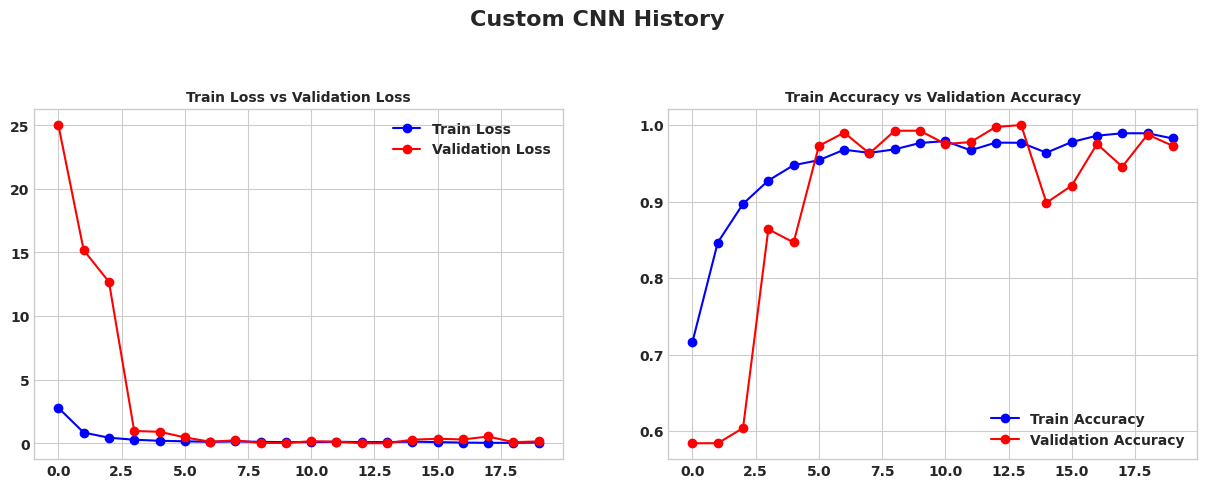

In [18]:
plt.figure(figsize=(15,10))
plt.suptitle('Custom CNN History', fontsize=16, weight='bold')

plt.subplot(2,2,1)
plt.plot(hist['loss'],'b-o',label='Train Loss')
plt.plot(hist['val_loss'],'r-o',label='Validation Loss')
plt.title('Train Loss vs Validation Loss',fontsize=10, weight='bold')
plt.legend()
plt.subplot(2,2,2)
plt.plot(hist['accuracy'],'b-o',label='Train Accuracy')
plt.plot(hist['val_accuracy'],'r-o',label='Validation Accuracy')
plt.title('Train Accuracy vs Validation Accuracy',fontsize=10, weight='bold')
plt.legend()

plt.show()

Confusion Matrix, Without Normalization
[[180  19]
 [  5 195]]


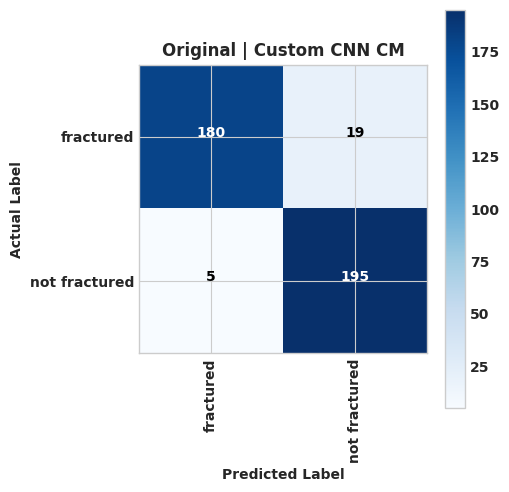

In [19]:
# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
plot_confusion_matrix(cm=cm, classes=labels, title='Original | Custom CNN CM')

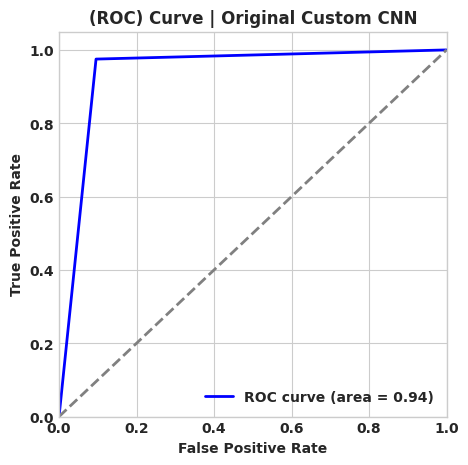

In [20]:
plot_roc_curve(y_test, y_pred)